# Global Solution - Front End
### O grupo: Caio Salesi, Gustavo Agostinho, Leonardo Sisilio
---
## O desafio:
Desenvolver um projeto que tenha como entregável um webapp, com Machine Learning embarcado, aplicado ao contexto de "Monitoramento e Conservação de Recifes de Coral". Pesquisar sobre fontes de dados relacionados ao tema para
criar uma interface interativa que exiba a saúde dos recifes e/ou identifique espécies ameaçadas e/ou detecte padrões de degradação ambiental, promovendo a sustentabilidade da Economia Azul.


### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Carregamento e Limpeza dos Dados

### Sobre o dataset

Link do Kaggle: https://www.kaggle.com/datasets/mehrdat/coral-reef-global-bleaching?select=coral.csv \
Link do projeto que gerou os dados: https://www.bco-dmo.org/project/762952 \

In [2]:
raw_df = pd.read_csv('coral.csv',encoding='utf-8')

In [3]:
raw_df.sample(5)

,Site_ID,Sample_ID,Data_Source,Latitude_Degrees,Longitude_Degrees,Ocean_Name,Reef_ID,Realm_Name,Ecoregion_Name,Country_Name,...,TSA_FrequencyMax,TSA_FrequencyMean,TSA_DHW,TSA_DHW_Standard_Deviation,TSA_DHWMax,TSA_DHWMean,Date,Site_Comments,Sample_Comments,Bleaching_Comments
35393,1352,10317986,Reef_Check,26.1426,50.7531,Arabian Gulf,50.45.183E.26.8.555N,Western Indo-Pacific,Persian Gulf,Bahrain,...,9,2,0,2.84,20.48,1.04,1998-06-05,nd,nd,nd
20047,8080,10312056,Reef_Check,25.1138,121.9202,Pacific,121.55.12.61E.25.6.49.69N,Temperate Northern Pacific,Taiwan and coastal China,Taiwan,...,6,0,0,0.89,7.58,0.28,2015-06-14,nd,nd,nd
35778,2187,10316832,Reef_Check,2.9569,-78.1792,Pacific,2N78W1,Tropical Eastern Pacific,Colombia Ecuador and Chile Pacific coast,Colombia,...,35,4,1.4,4.25,37.9,1.67,1998-09-27,nd,nd,nd
17565,6788,10315456,Reef_Check,-21.3803,164.9672,Pacific,164.58.035E.21.22.82S,Central Indo-Pacific,New Caledonia,New Caledonia,...,6,1,0,1.64,10.9,0.61,2008-11-09,nd,nd,nd
13814,5350,10313002,Reef_Check,24.9984,125.2704,Pacific,125.16.13.5E.24.59.54.3N,Central Indo-Pacific,South Ryukyu Islands Japan,Japan,...,8,1,0,1.33,12.13,0.38,2007-11-11,nd,nd,nd


In [4]:
raw_df.shape

(41361, 62)

###Categorias escolhidas:
Das 62 colunas originais, 12 foram mantidas. São elas:\
\
**Ocean_Name** (oceano onde a amostra foi coletada) \
**Ecoregion_Name** (subdivisão geográfica) \
**Distance_to_Shore** (distância da praia) \
**Exposure** (exposição do local, principalmente a ventos) \
**Turbidity** (turbidez da água) \
**Cyclone_Frequency** (frequência de ciclones) \
**Depth_m** (profundidade em metros) \
**Temperature_Kelvin** (temperatura em Kelvin) \
**Windspeed** (velocidade dos ventos em metros por hora) \
**SSTA** (cálculo da anomalia da temperatura da superfície do mar) \
**TSA** (cálculo da anomalia de estresse térmico) \
Target:
**Percent_Bleaching** (porcentagem de branqueamento) \

In [5]:
df = raw_df[['Ocean_Name', 'Ecoregion_Name', 'Distance_to_Shore', 'Exposure', 'Turbidity',
             'Cyclone_Frequency', 'Depth_m', 'Temperature_Kelvin', 'Windspeed',
             'SSTA', 'TSA', 'Percent_Bleaching']]

df.sample(5)

,Ocean_Name,Ecoregion_Name,Distance_to_Shore,Exposure,Turbidity,Cyclone_Frequency,Depth_m,Temperature_Kelvin,Windspeed,SSTA,TSA,Percent_Bleaching
8378,Pacific,Hong Kong,23.48,Sheltered,0.2825,53.46,10,301.08,4,-0.23,-0.62,0
34594,Atlantic,Jamaica,290.47,Exposed,0.0291,64.80,10,301.2,8,0.07,-1.31,55
37278,Pacific,Banda Sea and Molucca Islands,9.55,Sheltered,0.0,50.98,10,300.84,5,-0.17,-2.00,nd
38571,Atlantic,Belize and west Caribbean,863.8,Exposed,0.0,46.93,10,301.47,4,-0.51,-0.81,nd
18629,Pacific,South-east Philippines,987.2,Sheltered,0.0644,50.83,6,302.58,9,-0.17,-0.29,0.0


In [6]:
# Verificando os valores únicos das features
df.nunique().sort_values()

Exposure                  3
Ocean_Name                5
Windspeed                20
Ecoregion_Name          115
Depth_m                 473
SSTA                    667
TSA                    1127
Temperature_Kelvin     1243
Cyclone_Frequency      1747
Turbidity              2388
Percent_Bleaching      2500
Distance_to_Shore     13127
dtype: int64

As features **Ocean_Name** e **Ecoregion_Name** guardam o mesmo tipo de informação -- geográfica -- mas em escalas diferentes. Gostaríamos de usar **Ecoregion_Name** por ser mais exata, mas por ser uma variável categórica com mais de uma centena de valores únicos, não achamos vantajoso usar OneHotEncoding porque aumentaria muito a dimensionalidade do dataframe, e nem o LabelEncoding porque afetaria a interpretabilidade do modelo. \
Portanto escolhemos manter **Ocean_Name** e excluir **Ecoregion_Name**

In [7]:
df.drop('Ecoregion_Name', inplace = True, axis = 1)
df.sample(5)

,Ocean_Name,Distance_to_Shore,Exposure,Turbidity,Cyclone_Frequency,Depth_m,Temperature_Kelvin,Windspeed,SSTA,TSA,Percent_Bleaching
11622,Pacific,953.11,Exposed,0.0264,48.84,7,300.34,6,0.16,-1.73,0
23971,Pacific,2185.49,Sometimes,0.0757,54.44,12.3,303.96,3,0.93,0.82,0.25
5300,Atlantic,1661.68,Exposed,0.0396,65.39,5.79,300.44,7,0.31,-1.43,10
34399,Pacific,4147.52,Sometimes,0.0757,54.44,13,305.01,2,1.91,1.84,44.75
33605,Atlantic,4684.0,Sheltered,0.1051,57.05,2.8,303.35,6,1.61,0.31,23.16


Agora checamos os valores únicos das duas features categóricas que temos e em seguida fazemos o One Hot Encoding

In [8]:
print(df['Ocean_Name'].unique())
print(df['Exposure'].unique())

['Atlantic' 'Pacific' 'Indian' 'Arabian Gulf' 'Red Sea']
['Exposed' 'Sometimes' 'Sheltered']


In [9]:
df_oh_ocean = pd.get_dummies(df['Ocean_Name'], prefix='Ocean', dtype=int)
df_oh_expos = pd.get_dummies(df['Exposure'], prefix='Exposure', dtype=int)
df_oh = pd.concat([df_oh_ocean, df_oh_expos], axis=1)
df = df.drop(['Ocean_Name', 'Exposure'], axis=1)
df = pd.concat([df_oh, df], axis=1)

In [10]:
df.sample(10)

,Ocean_Arabian Gulf,Ocean_Atlantic,Ocean_Indian,Ocean_Pacific,Ocean_Red Sea,Exposure_Exposed,Exposure_Sheltered,Exposure_Sometimes,Distance_to_Shore,Turbidity,Cyclone_Frequency,Depth_m,Temperature_Kelvin,Windspeed,SSTA,TSA,Percent_Bleaching
21984,0,0,0,1,0,1,0,0,119.15,0.0355,61.64,10,302.64,7,0.64,0.46,0.0
19790,0,0,0,1,0,1,0,0,91.6,0.0655,63.43,7.5,299.82,7,-0.07,-2.08,0.0
13792,0,0,0,1,0,1,0,0,1901.84,0.0516,65.58,6,300.58,5,0.13,-1.6,0
31796,0,1,0,0,0,0,1,0,146.42,0.0603,49.45,12,299.99,7,-0.87,-2.69,10.0
2284,0,1,0,0,0,0,0,1,975.99,0.0286,49.10,15.55,299.85,6,-0.34,-2.40,16.7
35165,0,0,0,1,0,0,1,0,227.64,0.0758,63.92,3,300.48,5,0.55,-2.04,nd
13999,0,0,0,1,0,0,1,0,104.66,0.0988,48.82,8,301.73,1,-0.62,-1.34,0
15966,0,0,0,1,0,0,1,0,896.15,0.0644,54.37,5,302.59,2,0.84,-0.13,0
25848,0,0,0,1,0,1,0,0,4418.41,0.1087,49.23,12,297,7,0.37,-2.59,1.0
1283,0,0,0,1,0,0,1,0,2857.66,0.1922,46.94,nd,300.68,4,0.75,-2.11,75


Análise de NaN

In [11]:
df.isna().sum()

Ocean_Arabian Gulf    0
Ocean_Atlantic        0
Ocean_Indian          0
Ocean_Pacific         0
Ocean_Red Sea         0
Exposure_Exposed      0
Exposure_Sheltered    0
Exposure_Sometimes    0
Distance_to_Shore     0
Turbidity             0
Cyclone_Frequency     0
Depth_m               0
Temperature_Kelvin    0
Windspeed             0
SSTA                  0
TSA                   0
Percent_Bleaching     0
dtype: int64

Análise dos tipos

In [12]:
df.dtypes

Ocean_Arabian Gulf      int64
Ocean_Atlantic          int64
Ocean_Indian            int64
Ocean_Pacific           int64
Ocean_Red Sea           int64
Exposure_Exposed        int64
Exposure_Sheltered      int64
Exposure_Sometimes      int64
Distance_to_Shore      object
Turbidity              object
Cyclone_Frequency     float64
Depth_m                object
Temperature_Kelvin     object
Windspeed              object
SSTA                   object
TSA                    object
Percent_Bleaching      object
dtype: object

Ao pegar uma amostra da base notamos que embora não houvessem valores NaN, alguns registros tinham valor 'nd', o que os fazia assumir o tipo object. Agora fazemos a contagem desses registros para em seguida os tratar

In [13]:
# Contar quantos valores 'nd' temos em cada coluna do tipo 'object'
type_obj_columns = ['Distance_to_Shore', 'Turbidity', 'Depth_m', 'Temperature_Kelvin', 'Windspeed', 'SSTA', 'TSA', 'Percent_Bleaching']
df_contagem_nd = df[type_obj_columns].apply(lambda x: x.str.match(r'^nd$|^nd ').sum(), axis=0)
df_contagem_nd.columns = ['nd_' + column for column in type_obj_columns]

print(df_contagem_nd)

Distance_to_Shore        2
Turbidity                6
Depth_m               1799
Temperature_Kelvin     148
Windspeed              129
SSTA                   148
TSA                    148
Percent_Bleaching     6846
dtype: int64


Com exceção de **Depth_m** e **Percent_Bleaching**, a quantidade de registros com valor 'nd' é inexpressiva, portanto serão removidos. Quanto a essas duas colunas, serão completadas com as suas médias

In [14]:
# Filtrando os com valor 'nd' nas features selecionadas
mascara_nd = df[type_obj_columns].apply(lambda x: x.str.contains('nd', na=False).any(), axis=1)
df = df[~mascara_nd]

In [15]:
# Substituindo pela média em Depth_m
df['Depth_m'] = pd.to_numeric(df['Depth_m'], errors='coerce')
media = df['Depth_m'].mean()
df['Depth_m'].fillna(media, inplace=True)

In [16]:
# Substituindo pela média em Percent_Bleaching
df['Percent_Bleaching'] = pd.to_numeric(df['Percent_Bleaching'], errors='coerce')
media = df['Percent_Bleaching'].mean()
df['Percent_Bleaching'].fillna(media, inplace=True)

In [17]:
# Convertendo todos para float
df[type_obj_columns] = df[type_obj_columns].apply(pd.to_numeric, errors='coerce')
df.dtypes

Ocean_Arabian Gulf      int64
Ocean_Atlantic          int64
Ocean_Indian            int64
Ocean_Pacific           int64
Ocean_Red Sea           int64
Exposure_Exposed        int64
Exposure_Sheltered      int64
Exposure_Sometimes      int64
Distance_to_Shore     float64
Turbidity             float64
Cyclone_Frequency     float64
Depth_m               float64
Temperature_Kelvin    float64
Windspeed             float64
SSTA                  float64
TSA                   float64
Percent_Bleaching     float64
dtype: object

In [18]:
df.sample(10)

,Ocean_Arabian Gulf,Ocean_Atlantic,Ocean_Indian,Ocean_Pacific,Ocean_Red Sea,Exposure_Exposed,Exposure_Sheltered,Exposure_Sometimes,Distance_to_Shore,Turbidity,Cyclone_Frequency,Depth_m,Temperature_Kelvin,Windspeed,SSTA,TSA,Percent_Bleaching
4052,0,1,0,0,0,0,0,1,728.30,0.0273,49.10,10.05,299.04,6.0,-0.34,-3.23,30.50
7934,0,0,0,1,0,0,1,0,18.25,0.1053,49.82,10.00,303.81,3.0,0.31,0.22,0.00
30758,0,0,0,1,0,0,0,1,1396.24,0.0770,54.44,4.00,302.17,2.0,-0.88,-0.90,6.25
8581,0,0,0,1,0,0,1,0,55.33,0.4006,55.21,3.50,299.63,3.0,-1.96,-2.37,0.00
22522,0,1,0,0,0,0,0,1,2059.92,0.0393,54.08,14.00,300.77,4.0,0.19,-1.86,0.00
20361,0,0,0,1,0,0,1,0,109.09,0.0568,50.27,3.50,302.04,5.0,0.01,-1.49,0.00
1942,0,0,0,1,0,0,1,0,67.02,0.0628,55.80,12.00,298.46,3.0,0.63,-0.24,0.00
9082,0,0,0,0,1,0,1,0,96.19,0.0552,47.62,5.00,301.46,4.0,0.35,-0.48,0.00
22627,0,1,0,0,0,1,0,0,2518.92,0.0444,41.59,1.00,300.51,5.0,0.17,-1.67,0.00
25052,0,1,0,0,0,1,0,0,1594.81,0.0439,52.57,13.00,305.03,3.0,2.60,2.60,0.50


## Análise Exploratória dos Dados

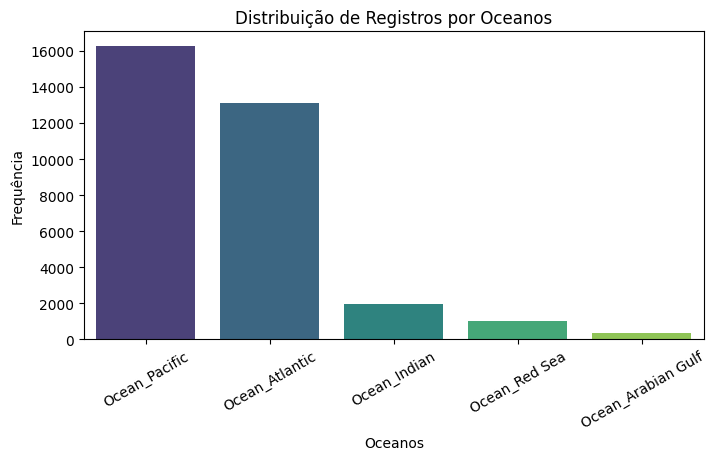

In [19]:
# Distribuição por Oceanos
ocean_columns = [col for col in df.columns if col.startswith('Ocean_')]
oceans_sums = df[ocean_columns].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=oceans_sums.index, y=oceans_sums.values, palette='viridis')
plt.title('Distribuição de Registros por Oceanos')
plt.xlabel('Oceanos')
plt.ylabel('Frequência')
plt.xticks(rotation=30)
plt.show()

Podemos notar que os oceanos com mais registros não por coincidência são os maiores

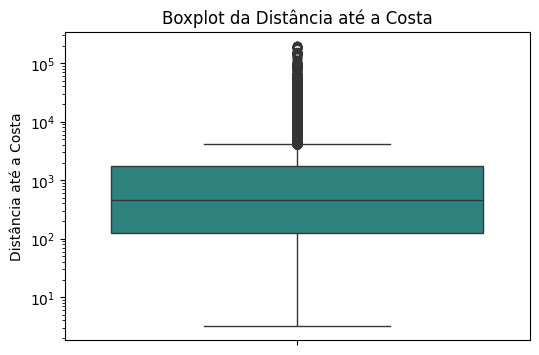

In [20]:
# Análise da Distância até a Costa
plt.figure(figsize=(6, 4))
sns.boxplot(y=df['Distance_to_Shore'], palette='viridis')
plt.yscale('log')
plt.title('Boxplot da Distância até a Costa')
plt.ylabel('Distância até a Costa')
plt.show()

A necessidade de ter usado a escala logarítimica e a grande quantidade de outliers mostra que há uma gigante variância na distância dos corais registrados até a costa mais próxima, entre poucos metros a muitos quilômetros, contudo a maioria está entre 100m e 1km.

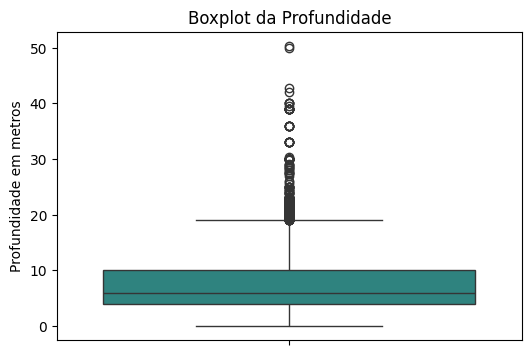

In [21]:
# Análise da Profundidade
plt.figure(figsize=(6, 4))
sns.boxplot(y=df['Depth_m'], palette='viridis')
plt.title('Boxplot da Profundidade')
plt.ylabel('Profundidade em metros')
plt.show()

O gráfico indica que apesar da maioria dos registros estar até 10 metros de profundidade, temos um outro pico significante próximo a 20 metros

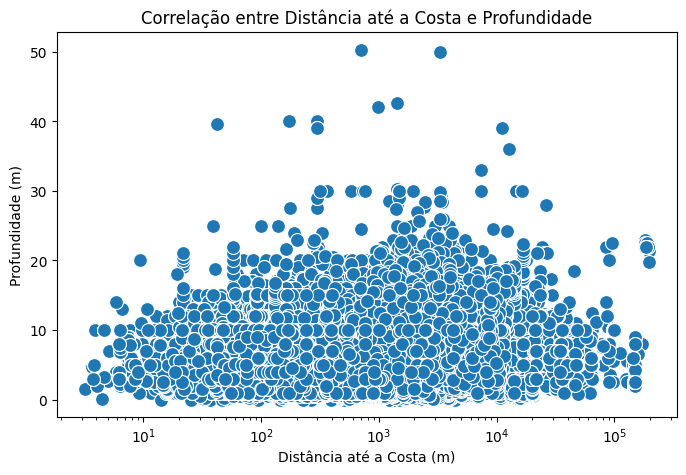

In [22]:
# Correlação entre Distância até a Costa e Profundidade
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Distance_to_Shore', y='Depth_m', data=df, palette='viridis', s=100)
plt.xscale('log')
plt.title('Correlação entre Distância até a Costa e Profundidade')
plt.xlabel('Distância até a Costa (m)')
plt.ylabel('Profundidade (m)')
plt.show()

Não parece haver correlação entre a Distância da Costa e a Profundidade

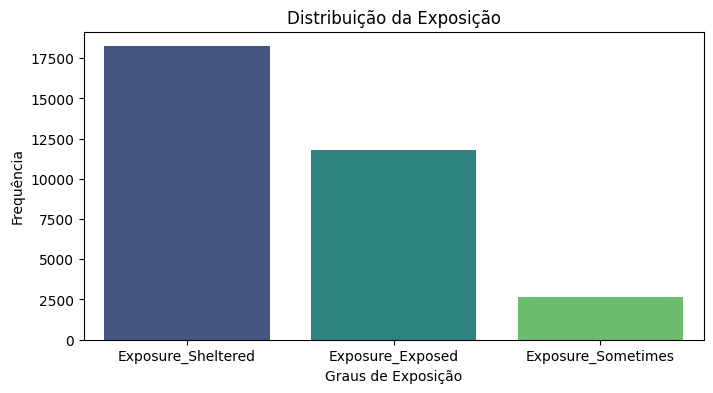

Exposure_Sheltered    18243
Exposure_Exposed      11794
Exposure_Sometimes     2677
dtype: int64


In [23]:
# Distribuição da Exposição
exposure_columns = [col for col in df.columns if col.startswith('Exposure_')]
expo_sums = df[exposure_columns].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=expo_sums.index, y=expo_sums.values, palette='viridis')
plt.title('Distribuição da Exposição')
plt.xlabel('Graus de Exposição')
plt.ylabel('Frequência')
plt.show()
print(expo_sums)

Mais da metade dos corais registrados estão em locais protegidos da erosão

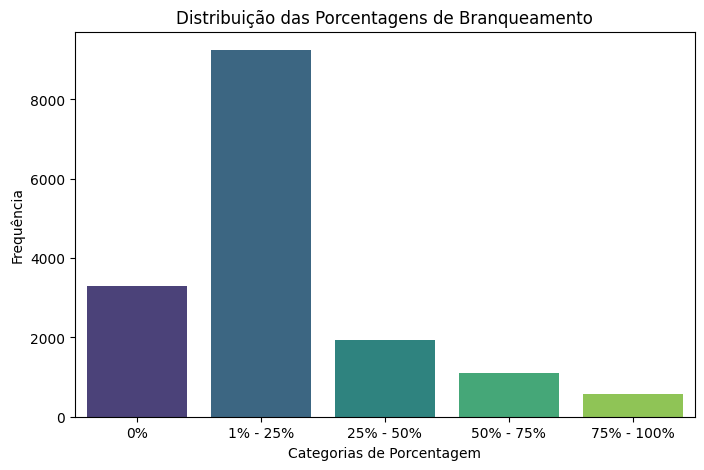

In [24]:
# Distribuição das Porcentagens de Branqueamento
category_ranges = [(0, 1), (1, 25), (25, 50), (50, 75), (75, 100)]
category_labels = ["0%", "1% - 25%", "25% - 50%", "50% - 75%", "75% - 100%"]

df_copy = df.copy()
df_copy['Percent_Bleaching_Category'] = pd.cut(df['Percent_Bleaching'], bins=[0, 1, 25, 50, 75, 100], labels=category_labels)

plt.figure(figsize=(8, 5))
sns.countplot(x='Percent_Bleaching_Category', data=df_copy, palette='viridis')
plt.title('Distribuição das Porcentagens de Branqueamento')
plt.xlabel('Categorias de Porcentagem')
plt.ylabel('Frequência')
plt.show()

Mais da metade dos corais registrados estão nas fases iniciais de branqueamento

## Modelagem

Esperamos com o modelo ter a capacidade de prever a probabilidade de um coral estar em processo de branqueamento dadas as circunstâncias do ambiente, mas também prever o grau desse possível processo, por isso escolhemos modelos de regressão. \
Três modelos foram escolhidos para serem testados: \
Regressão Linear \
Floresta Aleatória para Regressão \
LightGBM

In [25]:
# Imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb

Optamos por normalizar os dados, já que features como **Distance_to_Shore** e **Temperature_Kelvin** estão em escalas bem maiores que as outras. Escolhemos a normalização ao invés da padronização por se adaptar melhor as features codificadas com o OneHotEncoding que fizemos

In [26]:
# Separar features e target
X = df.drop('Percent_Bleaching', axis=1)
y = df['Percent_Bleaching']

# Normalizar e padronizar
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

### Modelo 1 - Regressão Linear

In [27]:
# Regressão Linear
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

### Modelo 2 - Floresta Aleatória para Regressão (com Grid Search)

In [28]:
# Floresta Aleatória para Regressão com GridSearchCV
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [15, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f'Melhores parâmetros: {grid_search.best_params_}')
best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Melhores parâmetros: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


### Modelo 3 - LightGBM

In [29]:
# LightGBM
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 30,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=15)])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1796
[LightGBM] [Info] Number of data points in the train set: 26171, number of used features: 16
[LightGBM] [Info] Start training from score 8.094613
Training until validation scores don't improve for 15 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 13.7927


# Métricas e Modelo Escolhido

In [41]:
# Linear Regression
y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f'Regressão Linear - MSE: {mse_lr}, R²: {r2_lr}')

Regressão Linear - MSE: 285.72658290802195, R²: 0.11399091140989293


In [42]:
# Random Forest Regressor
y_pred_rf = best_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Random Forest - MSE: {mse_rf}, R²: {r2_rf}')

Random Forest - MSE: 107.13736430952771, R²: 0.6677779241268984


In [43]:
# LightGBM
y_pred_gbm = gbm.predict(X_test, num_iteration=gbm.best_iteration)
mse_gbm = mean_squared_error(y_test, y_pred_gbm)
r2_gbm = r2_score(y_test, y_pred_gbm)
print(f'LightGBM - MSE: {mse_gbm}, R²: {r2_gbm}')

LightGBM - MSE: 190.23839724281103, R²: 0.4100900684826916


Nos baseando nessas métricas, entendemos que o modelo 2 - Random Forest Regressor é o mais adequado para nosso problema

# Exportação do Modelo

In [46]:
import pickle
with open('rf_regressor_model.pkl', 'wb') as file:
    pickle.dump(best_rf, file)

---